# Part 1: How accurate are moneylines and implied probabilities?

"Odds and lines aren't supposed to be about being perfect, they're supposed to invite action on both sides for the sportsbooks to make a profit."

Can we find games where the implied odds are more likely to be inefficient? This could help us spot opportunities for value bets.

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
from operator import attrgetter

%matplotlib inline
sns.set_style('whitegrid')

# Import datasets
# df_nba_lines_16 = pd.read_csv('./SBR_NBA_Lines_2016-17.csv')
df_nba_lines_17 = pd.read_csv('./SBR_NBA_Lines_2017-18.csv')
df_nba_lines_18 = pd.read_csv('./SBR_NBA_Lines_2018-19.csv')
df_nba_lines_19 = pd.read_csv('./SBR_NBA_Lines_2019-20.csv')

# Combine all into single dataframe
df_nba_lines = pd.concat([df_nba_lines_17, df_nba_lines_18, df_nba_lines_19], ignore_index=True)

In [2]:
# Function that calculates win probability from moneyline
def ml_to_win_prob(ml):
    if ml < 0:
        prob = -ml / (-ml + 100)
    else:
        prob = 100 / (ml + 100)

    return prob

In [3]:
# Data wrangling: add new columns for W/L outcomes and win probabilities
df_generator = df_nba_lines.iterrows()
for (i, row1), (j, row2) in zip(df_generator, df_generator):
    # Determine winner of each game and insert values in new column
    if row1['score'] < row2['score']:
        df_nba_lines.at[i, 'outcome'] = 'L'
        df_nba_lines.at[j, 'outcome'] = 'W'
    elif row1['score'] > row2['score']:
        df_nba_lines.at[i, 'outcome'] = 'W'
        df_nba_lines.at[j, 'outcome'] = 'L'

    # Calculate implied win probabilities for each team
    row1_win_prob = ml_to_win_prob(row1['ml_PIN'])
    row2_win_prob = ml_to_win_prob(row2['ml_PIN'])
    df_nba_lines.at[i, 'win_prob_PIN'] = row1_win_prob
    df_nba_lines.at[j, 'win_prob_PIN'] = row2_win_prob

    # Calculate NORMALIZED win probabilities for each team
    prob_sum = row1_win_prob + row2_win_prob
    df_nba_lines.at[i, 'win_prob_norm_PIN'] = row1_win_prob / prob_sum
    df_nba_lines.at[j, 'win_prob_norm_PIN'] = row2_win_prob / prob_sum

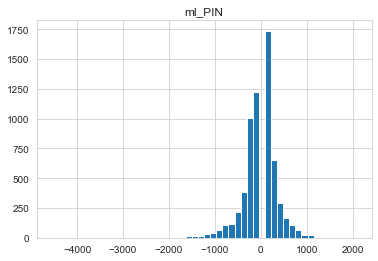

In [4]:
# Plot histogram
df_nba_lines.hist('ml_PIN', bins=50);

In [5]:
### Bucket games by ML and compare to actual win percentages. Are the ML actually predictive of final results?
# For now, we will only consider moneylines from Pinnacle!

# Place outcomes into bins based upon their pregame implied win probabilities
bins = 20
df_pin = df_nba_lines[['key', 'date', 'ml_time', 'team', 'opp_team', 'score', 'ml_PIN', 'outcome', 'win_prob_PIN', 'win_prob_norm_PIN']]
df_pin['bin'] = pd.cut(df_pin['win_prob_norm_PIN'], bins=bins)

###  Now, the goal is to calculate the win rate for each bin
# Start with grouping by bin and game outcome (W or L)
outcomes = df_pin.groupby(['bin', 'outcome']).size()

# Calculate the win AND loss rates for each bin based on game outcomes
win_rate = outcomes.groupby(level=0).apply(lambda x: x / float(x.sum()))

# Convert to df
df_win_rate = win_rate.reset_index(name='actual_win_rate')

# Filter only for win rate (remove loss rate and unneeded columns)
df_win_rate = df_win_rate[df_win_rate['outcome'] == 'W'][['bin', 'actual_win_rate']]

# Add column for the average implied win rate of each bin. This will the "expected win rate."
expected_win_rate_series = df_pin.groupby(['bin']).mean()['win_prob_norm_PIN']
df_win_rate = df_win_rate.assign(expected_win_rate = expected_win_rate_series.values)

# Calculate residuals (actual minus hypothetical)
df_win_rate['residual'] = df_win_rate['actual_win_rate'] - df_win_rate['expected_win_rate']

# Add column for the number of lines (teams) in each bin
size_series = df_pin.groupby(['bin']).size()
df_win_rate = df_win_rate.assign(count = size_series.values)

# Nicely formatted HTML table
df_win_rate.style.format({
    'actual_win_rate': '{:,.2%}'.format,
    'expected_win_rate': '{:,.2%}'.format,
    'residual': '{:,.2%}'.format
})

,bin,actual_win_rate,expected_win_rate,residual,count
1,"(0.0439, 0.0903]",9.09%,7.52%,1.57%,55
3,"(0.0903, 0.136]",11.62%,11.70%,-0.08%,198
5,"(0.136, 0.181]",19.40%,15.79%,3.61%,232
7,"(0.181, 0.227]",21.60%,20.35%,1.25%,287
9,"(0.227, 0.272]",25.38%,25.04%,0.34%,327
11,"(0.272, 0.318]",27.59%,29.58%,-1.98%,395
13,"(0.318, 0.363]",28.93%,34.09%,-5.15%,394
15,"(0.363, 0.409]",39.86%,38.62%,1.24%,446
17,"(0.409, 0.454]",47.78%,43.30%,4.48%,427
19,"(0.454, 0.5]",47.76%,47.67%,0.09%,426


,actual_win_rate,expected_win_rate,residual,count
actual_win_rate,1.000000,0.994974,-0.126593,-0.000696
expected_win_rate,0.994974,1.000000,-0.225283,-0.000713
residual,-0.126593,-0.225283,1.000000,0.000292
count,-0.000696,-0.000713,0.000292,1.000000


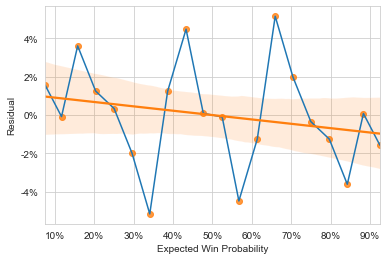

In [6]:
# Plot residuals

# Predicted vs. Residual
ax = sns.lineplot(x='expected_win_rate', y='residual', data=df_win_rate);
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.regplot(x='expected_win_rate', y='residual', data=df_win_rate, fit_reg=True);
ax.set(xlabel='Expected Win Probability', ylabel='Residual');

# Correlation
df_win_rate.corr()

# Part 2: Betting simulation

There appears to be some kind of effect here, but is the magnitude large enough to be a viable betting strategy? Let's take a look by running a simulation.

What happens if you only bet on heavy underdogs? Is there a threshold where a bet becomes a likely winner?


In [7]:
# Given moneyline odds and a bet amount, return the net profit from the bet (winnings)
def get_ml_bet_winnings(ml_odds, bet_amount):
    if ml_odds < 0:
        returns = (-100.0 / ml_odds) * bet_amount
    else:
        returns = (bet_amount / 100.0) * ml_odds
    return returns

# Quick and dirty function to test this calculator
def test_get_ml_bet_winnings():
    assert get_ml_bet_winnings(-200, 100) == 50
    assert abs(get_ml_bet_winnings(-220, 10) - 4.5454) <= .0001
    assert abs(get_ml_bet_winnings(-110, 69) == 62.7272) <= .0001
    assert get_ml_bet_winnings(150, 100) == 150
    assert get_ml_bet_winnings(100, 20) == 20
    assert get_ml_bet_winnings(3000, 15.5) == 465

test_get_ml_bet_winnings()

In [8]:
# Function that simulates a betting strategy

def simulate_bets(dataset_df=df_pin, bet_amount=100, win_prob_threshold=0.5):
    total_profit = 0
    all_winnings = []
    running_profits = []

    df_generator = dataset_df.iterrows()
    for (i, row1), (j, row2) in zip(df_generator, df_generator):
        ### 1. Determine who to bet on for this game
        t1_ml = row1['ml_PIN']
        t2_ml = row2['ml_PIN']
        t1_score = row1['score']
        t2_score = row2['score']
        t1_win_prob = row1['win_prob_norm_PIN']
        t2_win_prob = row2['win_prob_norm_PIN']

        # If any odds are missing, just skip the game
        if pd.isnull(t1_ml) or pd.isnull(t2_ml):
            continue

        if t1_win_prob < win_prob_threshold:
            placed_bet_on = 1
            bet_ml = t1_ml
        elif t2_win_prob <= win_prob_threshold:
            placed_bet_on = 2
            bet_ml = t2_ml
        else:
            # Not a favorable bet. Skip to next game
            continue

        ### 2. Deterimine if we won or lost this bet
        if t1_score > t2_score:
            game_winner = 1
        elif t2_score > t1_score:
            game_winner = 2
        else:
            # Throw out any games missing scores (shouldn't be any)
            continue
        
        is_win = game_winner == placed_bet_on

        ### 3. Calculate winnings from this bet

        # If favorite lost, then deduct bet from net profits
        if is_win is False:
            winnings = -bet_amount

        # If favorite won, then add winnings to net profits
        if is_win is True:
            winnings = get_ml_bet_winnings(bet_ml, bet_amount)

        ### 4. Record winnings and update total profits
        total_profit += winnings
        all_winnings.append(winnings)
        running_profits.append(total_profit)

    return total_profit, all_winnings, running_profits

7182.0


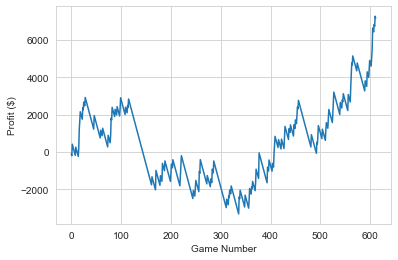

In [9]:
# Plot the running total of profits over time
profits, all_winnings, running_profits = simulate_bets(bet_amount=100, win_prob_threshold=0.2)
print(profits)
plt.plot(running_profits);
plt.xlabel('Game Number');
plt.ylabel('Profit ($)');


In [10]:
# Calculate profits for several different thresholds
thresholds = [.1, .15, .2, .25, .3, .4, .5]
all_profits = []

for threshold in thresholds:
    profits, _, _ = simulate_bets(bet_amount=100, win_prob_threshold=threshold)
    all_profits.append(profits)

print(all_profits)

[1220.0, -540.0, 7182.0, 4219.0, -1449.0, -5532.0, -3902.962827092111]
